In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

##Loading Fashion Dataset.

In [2]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

In [3]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

In [4]:
len(dataset)

60000

##Spliting train and dev set.

In [5]:
from torch.utils.data import random_split

In [6]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

##Creating DataLoader

In [7]:
from torch.utils.data import DataLoader

In [8]:
train_loader = DataLoader(train_ds, batch_size = 128, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 128*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Visualizing Data.

In [9]:
image , label = dataset[6]

In [10]:
image.shape

torch.Size([1, 28, 28])

Label :  Sneaker


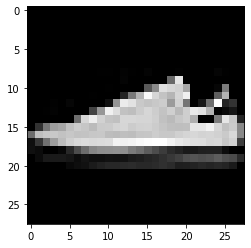

In [11]:
print("Label : ",dataset.classes[label])
plt.imshow(image[0], cmap='gray')
plt.show()

In [12]:
from torchvision.utils import make_grid

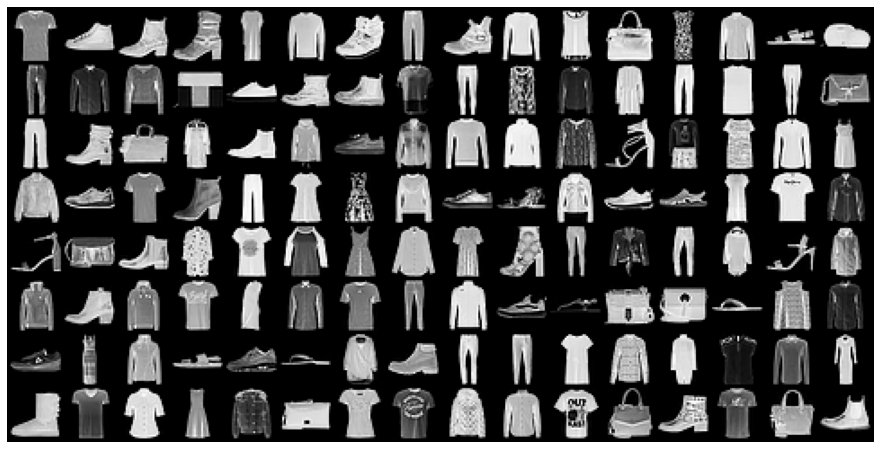

In [13]:
for images,_ in train_loader:
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

##Creating Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class FashionMnistModel(nn.Module):
  def __init__(self,num_inputs,hidden_layer,num_outputs):
    super().__init__()
    self.linear1 = nn.Linear(num_inputs,hidden_layer)
    self.linear2 = nn.Linear(hidden_layer,num_outputs)
  
  def forward(self,xb):
    out = xb.view(xb.size(0), -1)
    
    output = self.linear1(out)
    output = F.relu(output)

    output = self.linear2(output)
    output = F.relu(output)

    return output
  
  def training_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss , 'val_acc': acc}
  
  def validation_epoch_end(self,outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

##Connecting to GPU.

In [17]:
torch.cuda.is_available() 

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [21]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Moving data to GPU.

In [22]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

##Using the Created Model

In [23]:
def evaluate(model,val_dl):
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

In [24]:
def fit(epochs,lr,model,train_dl,val_dl,opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model,val_dl)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [25]:
input_size = 784
hidden_layer = 32
output_size = 10

In [26]:
model = FashionMnistModel(input_size,hidden_layer,output_size)
to_device(model,device)

FashionMnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.30946683883667, 'val_acc': 0.08564452826976776}]

In [28]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7759, val_acc: 0.7161
Epoch [1], val_loss: 0.8771, val_acc: 0.6993
Epoch [2], val_loss: 0.7433, val_acc: 0.7142
Epoch [3], val_loss: 0.6402, val_acc: 0.7604
Epoch [4], val_loss: 0.6442, val_acc: 0.7557
Epoch [5], val_loss: 0.6204, val_acc: 0.7657
Epoch [6], val_loss: 0.6763, val_acc: 0.7443
Epoch [7], val_loss: 0.6416, val_acc: 0.7589
Epoch [8], val_loss: 0.6268, val_acc: 0.7650
Epoch [9], val_loss: 0.6492, val_acc: 0.7619


In [29]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5814, val_acc: 0.7810
Epoch [1], val_loss: 0.5806, val_acc: 0.7812
Epoch [2], val_loss: 0.5789, val_acc: 0.7816
Epoch [3], val_loss: 0.5860, val_acc: 0.7813
Epoch [4], val_loss: 0.5804, val_acc: 0.7833
Epoch [5], val_loss: 0.5804, val_acc: 0.7805
Epoch [6], val_loss: 0.5772, val_acc: 0.7844
Epoch [7], val_loss: 0.5788, val_acc: 0.7838
Epoch [8], val_loss: 0.5744, val_acc: 0.7828
Epoch [9], val_loss: 0.5843, val_acc: 0.7816


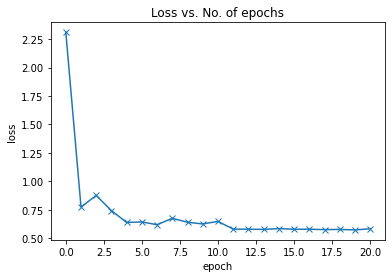

In [30]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

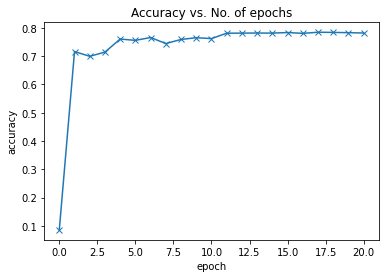

In [31]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [32]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.5972170829772949, 'val_acc': 0.77880859375}